In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

In [2]:
train_file = 'data/out/train_cleaned.csv'
test_file = 'data/out/test_cleaned.csv'

In [3]:
train_data = pd.read_csv(train_file)
train_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
test_data = pd.read_csv(test_file)
test_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
train_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia,tiempo,distancia_api,tiempo_api,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,13573.1,1285.1,...,1,0,0,0,0,0,0,0,0,0
1,124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,14549.1,1210.1,...,1,0,0,0,0,0,0,0,0,0
2,124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,58253.0,3680.0,...,0,0,0,0,0,0,0,0,0,0
3,124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,23597.4,1472.8,...,0,0,0,0,0,0,0,0,0,0
4,124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,14608.3,1154.8,...,1,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia_api,tiempo_api,region_origen_Amazonas,region_origen_Ancash,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,76381.7,4891.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,124606.8,10232.9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,20630.3,1631.7,0,0,...,1,0,0,0,0,0,0,0,0,0
3,124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,12105.8,1067.6,0,0,...,1,0,0,0,0,0,0,0,0,0
4,124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,9403.2,652.5,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
train_data.shape

(1952, 59)

In [7]:
test_data.shape

(852, 57)

In [8]:
X=train_data.loc[:,train_data.columns.isin(['id','fecha','distancia','tiempo']) == False].values
y=train_data.iloc[:,6:8].values
yhat=test_data.iloc[:,2:].values

In [9]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, ..., 0.        , 0.        ,
        0.        ],
       [0.74842017, 0.22806174, 0.72358461, ..., 0.        , 0.        ,
        0.        ],
       [0.4134065 , 0.34430488, 0.41945535, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, ..., 0.        , 0.        ,
        0.        ],
       [0.40340026, 0.3552709 , 0.42098601, ..., 0.        , 0.        ,
        0.        ],
       [0.15010318, 0.93230005, 0.23882396, ..., 0.        , 0.        ,
        0.        ]])

In [10]:
from keras.optimizers import Adam

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer=Adam(learning_rate=0.5e-3))
    return model

In [11]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
print(X.shape[1], y.shape[1])

55 2


In [12]:
from keras.callbacks import ModelCheckpoint

def get_callbacks():
    filepath = 'data/out/try6.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try6.csv')
    
    return [callback1,callback2]

In [13]:
model = get_model(n_inputs, n_outputs)
history = model.fit(X, y, verbose=1, epochs=300, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/300
49/49 [==============================] - 1s 21ms/step - loss: 185.4333 - val_loss: 145.8059

Epoch 00001: loss improved from inf to 171.46716, saving model to data/out\try6.h5
Epoch 2/300
49/49 [==============================] - 0s 1ms/step - loss: 130.5850 - val_loss: 91.2274

Epoch 00002: loss improved from 171.46716 to 118.18813, saving model to data/out\try6.h5
Epoch 3/300
49/49 [==============================] - 0s 2ms/step - loss: 78.6902 - val_loss: 60.3739

Epoch 00003: loss improved from 118.18813 to 69.98416, saving model to data/out\try6.h5
Epoch 4/300
49/49 [==============================] - 0s 1ms/step - loss: 60.1292 - val_loss: 57.6722

Epoch 00004: loss improved from 69.98416 to 59.01615, saving model to data/out\try6.h5
Epoch 5/300
49/49 [==============================] - 0s 1ms/step - loss: 57.0098 - val_loss: 54.9907

Epoch 00005: loss improved from 59.01615 to 56.35471, saving model to data/out\try6.h5
Epoch 6/300
49/49 [==============================] -

49/49 [==============================] - 0s 1ms/step - loss: 13.0681 - val_loss: 14.0100

Epoch 00045: loss improved from 13.21307 to 13.15734, saving model to data/out\try6.h5
Epoch 46/300
49/49 [==============================] - 0s 2ms/step - loss: 13.3680 - val_loss: 14.0292

Epoch 00046: loss improved from 13.15734 to 13.14319, saving model to data/out\try6.h5
Epoch 47/300
49/49 [==============================] - 0s 2ms/step - loss: 13.1429 - val_loss: 13.9996

Epoch 00047: loss improved from 13.14319 to 13.13179, saving model to data/out\try6.h5
Epoch 48/300
49/49 [==============================] - 0s 1ms/step - loss: 13.0170 - val_loss: 13.9305

Epoch 00048: loss improved from 13.13179 to 13.05663, saving model to data/out\try6.h5
Epoch 49/300
49/49 [==============================] - 0s 2ms/step - loss: 13.0957 - val_loss: 13.9133

Epoch 00049: loss did not improve from 13.05663
Epoch 50/300
49/49 [==============================] - 0s 1ms/step - loss: 13.4252 - val_loss: 13.8886


49/49 [==============================] - 0s 1ms/step - loss: 13.0151 - val_loss: 13.5758

Epoch 00092: loss improved from 12.52378 to 12.50198, saving model to data/out\try6.h5
Epoch 93/300
49/49 [==============================] - 0s 2ms/step - loss: 12.4320 - val_loss: 13.5877

Epoch 00093: loss did not improve from 12.50198
Epoch 94/300
49/49 [==============================] - 0s 2ms/step - loss: 12.4597 - val_loss: 13.8258

Epoch 00094: loss did not improve from 12.50198
Epoch 95/300
49/49 [==============================] - 0s 1ms/step - loss: 12.4769 - val_loss: 13.5694

Epoch 00095: loss improved from 12.50198 to 12.48991, saving model to data/out\try6.h5
Epoch 96/300
49/49 [==============================] - 0s 1ms/step - loss: 12.9828 - val_loss: 13.5673

Epoch 00096: loss improved from 12.48991 to 12.46389, saving model to data/out\try6.h5
Epoch 97/300
49/49 [==============================] - 0s 1ms/step - loss: 12.7685 - val_loss: 13.5727

Epoch 00097: loss did not improve from

49/49 [==============================] - 0s 1ms/step - loss: 11.8009 - val_loss: 13.4367

Epoch 00142: loss did not improve from 12.28676
Epoch 143/300
49/49 [==============================] - 0s 2ms/step - loss: 12.4787 - val_loss: 13.5971

Epoch 00143: loss improved from 12.28676 to 12.26752, saving model to data/out\try6.h5
Epoch 144/300
49/49 [==============================] - 0s 1ms/step - loss: 12.4069 - val_loss: 13.4777

Epoch 00144: loss did not improve from 12.26752
Epoch 145/300
49/49 [==============================] - 0s 1ms/step - loss: 12.0790 - val_loss: 13.5184

Epoch 00145: loss did not improve from 12.26752
Epoch 146/300
49/49 [==============================] - 0s 2ms/step - loss: 12.3723 - val_loss: 13.4734

Epoch 00146: loss did not improve from 12.26752
Epoch 147/300
49/49 [==============================] - 0s 2ms/step - loss: 12.1865 - val_loss: 13.4097

Epoch 00147: loss did not improve from 12.26752
Epoch 148/300
49/49 [==============================] - 0s 2ms/s

49/49 [==============================] - 0s 1ms/step - loss: 12.5193 - val_loss: 13.5517

Epoch 00194: loss did not improve from 12.19899
Epoch 195/300
49/49 [==============================] - 0s 1ms/step - loss: 12.6564 - val_loss: 13.3865

Epoch 00195: loss did not improve from 12.19899
Epoch 196/300
49/49 [==============================] - 0s 1ms/step - loss: 12.1729 - val_loss: 13.3716

Epoch 00196: loss did not improve from 12.19899
Epoch 197/300
49/49 [==============================] - 0s 1ms/step - loss: 12.1557 - val_loss: 13.3595

Epoch 00197: loss improved from 12.19899 to 12.18123, saving model to data/out\try6.h5
Epoch 198/300
49/49 [==============================] - 0s 1ms/step - loss: 12.2996 - val_loss: 13.4518

Epoch 00198: loss did not improve from 12.18123
Epoch 199/300
49/49 [==============================] - 0s 1ms/step - loss: 11.7186 - val_loss: 13.3609

Epoch 00199: loss did not improve from 12.18123
Epoch 200/300
49/49 [==============================] - 0s 1ms/s

49/49 [==============================] - 0s 2ms/step - loss: 11.8851 - val_loss: 13.3476

Epoch 00246: loss did not improve from 12.14316
Epoch 247/300
49/49 [==============================] - 0s 1ms/step - loss: 12.5791 - val_loss: 13.3025

Epoch 00247: loss did not improve from 12.14316
Epoch 248/300
49/49 [==============================] - 0s 1ms/step - loss: 11.8838 - val_loss: 13.3031

Epoch 00248: loss did not improve from 12.14316
Epoch 249/300
49/49 [==============================] - 0s 2ms/step - loss: 11.7548 - val_loss: 13.3098

Epoch 00249: loss did not improve from 12.14316
Epoch 250/300
49/49 [==============================] - 0s 1ms/step - loss: 12.0522 - val_loss: 13.4229

Epoch 00250: loss did not improve from 12.14316
Epoch 251/300
49/49 [==============================] - 0s 1ms/step - loss: 12.7195 - val_loss: 13.3153

Epoch 00251: loss did not improve from 12.14316
Epoch 252/300
49/49 [==============================] - 0s 1ms/step - loss: 11.5627 - val_loss: 13.4562

49/49 [==============================] - 0s 1ms/step - loss: 11.9908 - val_loss: 13.2796

Epoch 00299: loss did not improve from 12.10788
Epoch 300/300
49/49 [==============================] - 0s 1ms/step - loss: 12.3912 - val_loss: 13.3120

Epoch 00300: loss did not improve from 12.10788


In [14]:
#Cargando el mejor modelo

from keras.models import load_model
best_model_tf = load_model('data/out/try6.h5')

ypred = best_model_tf.predict(yhat)

In [15]:
print(ypred)

[[ 76700.76     5359.0874]
 [126495.164   11427.147 ]
 [ 20863.316    2129.6433]
 ...
 [ 24664.32     2382.7173]
 [ 92645.97     7639.051 ]
 [166772.56     8914.409 ]]


In [16]:
best_model_tf.evaluate(X,y)

61/61 [==============================] - 0s 433us/step - loss: 12.4936


12.493582725524902

In [17]:
ids = pd.read_csv(test_file)
ids_1 = ids['id']

In [18]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   76700.757812   5359.087402
1    124093149  126495.164062  11427.147461
2    124090750   20863.316406   2129.643311
3    124092491   12293.953125   1529.770142
4    124091871    9435.025391   1040.870605
..         ...            ...           ...
847  124088805   15085.156250   1811.820557
848  124089757   11962.061523   1367.827148
849  124089569   24664.320312   2382.717285
850  124092518   92645.968750   7639.050781
851  124090644  166772.562500   8914.409180

[852 rows x 3 columns]


In [19]:
df.to_csv('data/out/try6_out.csv',index=False)

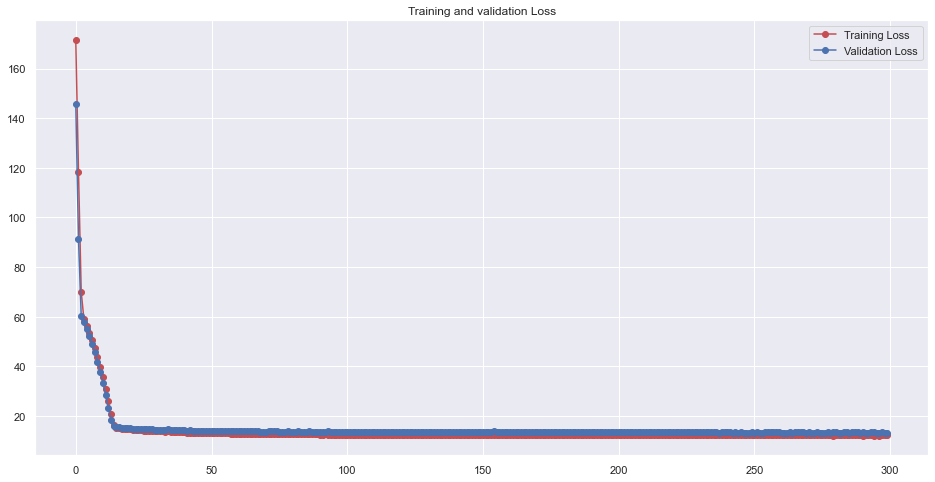

<Figure size 432x288 with 0 Axes>

In [20]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()